EXTRA (APÉNDICE)

En este notebook se entrenan diferentes modelos predictivos usando la puntuación OASIS para predecir la mortalidad hospitalaria. Luego se evalua el rendimiento de los modelos con ACC, AUC-ROC, AUC-PR, confusion matrix...También se realiza Cross Validation y student-t-test para determinar si las diferencias entre los resultados son estadísticamente significativas.

Obs. Ejecute primero '03calculateOASIS.ipynb' para obtener 'result_24_horas_final.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab
import seaborn as sns
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

matplotlib.style.use('ggplot')

In [2]:
patients=pd.read_csv('/home/usuario/TFG/code/data/PATIENTS.csv')
print(patients.shape)
print('unique SUBJECT_ID:', patients.SUBJECT_ID.nunique())
patients.head()

(46520, 8)
unique SUBJECT_ID: 46520


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [3]:
admissions=pd.read_csv('/home/usuario/TFG/code/data/ADMISSIONS.csv')
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
admissions.head()

(58976, 19)
unique SUBJECT_ID: 46520
unique HADM_ID   : 58976


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
admissions = admissions[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DEATHTIME']]
admissions.head(5)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN


In [5]:
admissions=pd.merge(patients, admissions, on=['SUBJECT_ID'])
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
admissions.head()

(58976, 12)
unique SUBJECT_ID: 46520
unique HADM_ID   : 58976


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN
1,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN
2,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN
3,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00
4,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN


In [6]:
admissions = admissions.drop(['ROW_ID','GENDER','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],axis=1)
admissions.head(5)

,SUBJECT_ID,DOB,DOD,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME
0,249,2075-03-13 00:00:00,NaN,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN
1,249,2075-03-13 00:00:00,NaN,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN
2,249,2075-03-13 00:00:00,NaN,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN
3,250,2164-12-27 00:00:00,2188-11-22 00:00:00,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00
4,251,2090-03-15 00:00:00,NaN,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN


In [7]:
icustays=pd.read_csv('/home/usuario/TFG/code/data/ICUSTAYS.csv')
print(icustays.shape)
print('unique SUBJECT_ID:', icustays.SUBJECT_ID.nunique())
print('unique HADM_ID   :', icustays.HADM_ID.nunique())
print('unique ICUSTAY_ID:', icustays.ICUSTAY_ID.nunique())
icustays.head()

(61532, 12)
unique SUBJECT_ID: 46476
unique HADM_ID   : 57786
unique ICUSTAY_ID: 61532


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [8]:
icustays=icustays.drop(['ROW_ID','DBSOURCE', 'FIRST_CAREUNIT','LAST_CAREUNIT','FIRST_WARDID', 'LAST_WARDID','LOS'], axis=1)

In [9]:
admissions=pd.merge(admissions, icustays, on=['SUBJECT_ID', 'HADM_ID'])
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
print('unique ICUSTAY_ID:', admissions.ICUSTAY_ID.nunique())
admissions.head()

(61532, 10)
unique SUBJECT_ID: 46476
unique HADM_ID   : 57786
unique ICUSTAY_ID: 61532


,SUBJECT_ID,DOB,DOD,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ICUSTAY_ID,INTIME,OUTTIME
0,249,2075-03-13 00:00:00,NaN,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN,215044,2149-12-18 20:06:02,2149-12-24 13:31:45
1,249,2075-03-13 00:00:00,NaN,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN,269035,2155-02-03 20:17:29,2155-02-05 18:34:02
2,249,2075-03-13 00:00:00,NaN,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN,263055,2155-02-07 18:51:16,2155-02-11 16:00:39
3,249,2075-03-13 00:00:00,NaN,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN,282599,2156-05-01 18:10:12,2156-05-03 18:43:45
4,249,2075-03-13 00:00:00,NaN,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN,263882,2156-05-10 17:47:35,2156-05-11 19:16:03


In [10]:
admissions['DOD'] = pd.to_datetime(admissions['DOD'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])


In [11]:
admissions['MORTALITY_INHOSPITAL'] = admissions['DOD'].notnull() & ((admissions['ADMITTIME'] <= admissions['DOD']) & (admissions['DISCHTIME'] >= admissions['DOD']))
admissions['MORTALITY_INHOSPITAL'] = admissions['MORTALITY_INHOSPITAL'] | (admissions['DEATHTIME'].notnull() & ((admissions['ADMITTIME'] <= admissions['DEATHTIME']) & (admissions['DISCHTIME'] >= admissions['DEATHTIME'])))
admissions['MORTALITY_INHOSPITAL'] = admissions['MORTALITY_INHOSPITAL'].astype(int)

In [12]:
admissions['MORTALITY_INHOSPITAL'].value_counts()  #OBSERVACION: tenemos 61532 filas con icustays distintas

0    54948
1     6584
Name: MORTALITY_INHOSPITAL, dtype: int64

In [13]:
admissions['INTIME'] = pd.to_datetime(admissions['INTIME'])
admissions['OUTTIME'] = pd.to_datetime(admissions['OUTTIME'])


In [14]:
admissions['MORTALITY_INUNIT'] = admissions['DOD'].notnull() & ((admissions['INTIME'] <= admissions['DOD']) & (admissions['OUTTIME'] >= admissions['DOD']))
admissions['MORTALITY_INUNIT'] = admissions['MORTALITY_INUNIT'] | (admissions['DEATHTIME'].notnull() & ((admissions['INTIME'] <= admissions['DEATHTIME']) & (admissions['OUTTIME'] >= admissions['DEATHTIME'])))
admissions['MORTALITY_INUNIT'] = admissions['MORTALITY_INUNIT'].astype(int)

In [15]:
admissions['MORTALITY_INUNIT'].value_counts()

0    56845
1     4687
Name: MORTALITY_INUNIT, dtype: int64

In [16]:
admissions

,SUBJECT_ID,DOB,DOD,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ICUSTAY_ID,INTIME,OUTTIME,MORTALITY_INHOSPITAL,MORTALITY_INUNIT
0,249,2075-03-13 00:00:00,NaT,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaT,215044,2149-12-18 20:06:02,2149-12-24 13:31:45,0,0
1,249,2075-03-13 00:00:00,NaT,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaT,269035,2155-02-03 20:17:29,2155-02-05 18:34:02,0,0
2,249,2075-03-13 00:00:00,NaT,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaT,263055,2155-02-07 18:51:16,2155-02-11 16:00:39,0,0
3,249,2075-03-13 00:00:00,NaT,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaT,282599,2156-05-01 18:10:12,2156-05-03 18:43:45,0,0
4,249,2075-03-13 00:00:00,NaT,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaT,263882,2156-05-10 17:47:35,2156-05-11 19:16:03,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,44089,2026-05-25 00:00:00,NaT,165748,2111-09-30 12:04:00,2111-10-03 16:04:00,NaT,292151,2111-09-30 18:53:12,2111-10-01 20:03:50,0,0
61528,44115,2124-07-27 00:00:00,NaT,163623,2161-07-15 12:00:00,2161-07-19 12:30:00,NaT,264947,2161-07-15 17:16:25,2161-07-16 13:21:38,0,0
61529,44123,2049-11-26 00:00:00,2135-01-12,116395,2135-01-06 07:15:00,2135-01-12 02:50:00,2135-01-12 02:50:00,264065,2135-01-06 09:54:24,2135-01-12 04:50:52,1,1
61530,44126,2076-07-25 00:00:00,NaT,183530,2129-01-03 07:15:00,2129-01-11 12:29:00,NaT,241939,2129-01-05 16:51:31,2129-01-07 18:03:39,0,0


In [17]:
result_24_horas_final=pd.read_csv('result_24_horas_final.csv')

In [18]:
result_24_horas_final.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                  10
AGE                   0
PRELOS                0
OASIS             13655
OASIS_NONAN           0
dtype: int64

In [19]:
result_24_horas_final = result_24_horas_final[result_24_horas_final['LOS'].notnull()] 
result_24_horas_final.isnull().sum()

Unnamed: 0            0
Unnamed: 0.1          0
SUBJECT_ID            0
HADM_ID               0
ADMITTIME             0
ADMISSION_TYPE        0
ICUSTAY_ID            0
INTIME                0
LOS                   0
AGE                   0
PRELOS                0
OASIS             13645
OASIS_NONAN           0
dtype: int64

In [20]:
result_24_horas_final = result_24_horas_final[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','OASIS_NONAN']]
result_24_horas_final = result_24_horas_final.reset_index(drop=True)
result_24_horas_final

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,OASIS_NONAN
0,59618,101145,226547,33.0
1,69108,158993,297532,29.0
2,14008,173497,217593,20.0
3,2187,128059,212355,0.0
4,41040,118624,224627,41.0
...,...,...,...,...
61517,83901,193465,286029,29.0
61518,10422,113048,227248,34.0
61519,14743,115333,298656,30.0
61520,99517,144548,213415,43.0


## Predecimos in-hospital-mortality

### Cohort Selection:

In [22]:
#we compute the age at the time the patient is admitted to the ICU from date of birth dob, then we drop dob.
admissions['DOB'] = pd.to_datetime(admissions['DOB']).dt.date
admissions['INTIME_TMP'] = pd.to_datetime(admissions['INTIME']).dt.date
admissions['AGE'] = admissions.apply(lambda e: (e['INTIME_TMP'] - e['DOB']).days/365, axis=1)
admissions=admissions.drop(['DOB','INTIME_TMP'], axis=1)

In [23]:
#Excluir admissions < 18 years old
admissions_filtradas = admissions[~(admissions['AGE'] < 18)]
print(admissions_filtradas.shape)
print('unique SUBJECT_ID:', admissions_filtradas.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions_filtradas.HADM_ID.nunique())
print('unique ICUSTAY_ID:', admissions_filtradas.ICUSTAY_ID.nunique())
admissions_filtradas.head()

(53332, 12)
unique SUBJECT_ID: 38512
unique HADM_ID   : 49695
unique ICUSTAY_ID: 53332


,SUBJECT_ID,DOD,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ICUSTAY_ID,INTIME,OUTTIME,MORTALITY_INHOSPITAL,MORTALITY_INUNIT,AGE
0,249,NaT,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaT,215044,2149-12-18 20:06:02,2149-12-24 13:31:45,0,0,74.816438
1,249,NaT,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaT,269035,2155-02-03 20:17:29,2155-02-05 18:34:02,0,0,79.947945
2,249,NaT,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaT,263055,2155-02-07 18:51:16,2155-02-11 16:00:39,0,0,79.958904
3,249,NaT,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaT,282599,2156-05-01 18:10:12,2156-05-03 18:43:45,0,0,81.189041
4,249,NaT,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaT,263882,2156-05-10 17:47:35,2156-05-11 19:16:03,0,0,81.213699


In [26]:
admissions_filtradas.loc[admissions_filtradas['SUBJECT_ID'] == 59618]
#Ejemplo de un SUBJECT_ID con dos ICUSTAY_ID pero son de HADM_ID distintas.

,SUBJECT_ID,DOD,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ICUSTAY_ID,INTIME,OUTTIME,MORTALITY_INHOSPITAL,MORTALITY_INUNIT,AGE
34933,59618,2102-02-11,101145,2102-01-20 20:38:00,2102-01-25 15:00:00,NaT,226547,2102-01-20 20:39:57,2102-01-21 20:33:19,0,0,74.430137
34934,59618,2102-02-11,157029,2102-02-09 18:14:00,2102-02-11 01:00:00,2102-02-11 01:00:00,275273,2102-02-09 18:15:37,2102-02-11 01:42:05,1,1,74.484932


### Predecir  in-hospital-mortality  con oasis calculada en 24  horas  (considerando los oasis_variable nan como 0.0 (usar np.nansum), i.e. en rango 'normal') + dataset original, no balanceado + mismo cohorte que benchmark

In [27]:
result_24_horas_final=pd.merge(result_24_horas_final, admissions_filtradas, on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])

In [28]:
print(result_24_horas_final.shape)
print('unique SUBJECT_ID:', result_24_horas_final.SUBJECT_ID.nunique())
print('unique HADM_ID   :', result_24_horas_final.HADM_ID.nunique())
print('unique ICUSTAY_ID   :', result_24_horas_final.ICUSTAY_ID.nunique())
result_24_horas_final.head()

(53329, 13)
unique SUBJECT_ID: 38510
unique HADM_ID   : 49692
unique ICUSTAY_ID   : 53329


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,OASIS_NONAN,DOD,ADMITTIME,DISCHTIME,DEATHTIME,INTIME,OUTTIME,MORTALITY_INHOSPITAL,MORTALITY_INUNIT,AGE
0,59618,101145,226547,33.0,2102-02-11,2102-01-20 20:38:00,2102-01-25 15:00:00,NaT,2102-01-20 20:39:57,2102-01-21 20:33:19,0,0,74.430137
1,69108,158993,297532,29.0,NaT,2132-01-15 23:26:00,2132-01-23 18:40:00,NaT,2132-01-16 06:22:40,2132-01-17 16:25:18,0,0,79.257534
2,14008,173497,217593,20.0,2137-04-28,2136-01-31 07:30:00,2136-02-05 12:10:00,NaT,2136-01-31 18:37:56,2136-02-01 18:10:13,0,0,76.789041
3,2187,128059,212355,0.0,2135-03-15,2134-04-21 02:22:00,2134-04-26 17:30:00,NaT,2134-04-21 02:24:10,2134-04-26 17:37:04,0,0,46.487671
4,41040,118624,224627,41.0,2135-09-03,2135-05-07 11:39:00,2135-05-17 13:50:00,NaT,2135-05-07 11:40:19,2135-05-12 17:41:46,0,0,80.178082


In [29]:
result_24_horas_nonnan=result_24_horas_final[['MORTALITY_INHOSPITAL','OASIS_NONAN','ICUSTAY_ID']]
result_24_horas_nonnan.head()

,MORTALITY_INHOSPITAL,OASIS_NONAN,ICUSTAY_ID
0,0,33.0,226547
1,0,29.0,297532
2,0,20.0,217593
3,0,0.0,212355
4,0,41.0,224627


In [30]:
result_24_horas_nonnan['MORTALITY_INHOSPITAL'].value_counts()

0    46814
1     6515
Name: MORTALITY_INHOSPITAL, dtype: int64

In [31]:
result_24_horas_nonnan=result_24_horas_nonnan.dropna()
result_24_horas_nonnan.shape

(53329, 3)

Normalmente basta con train_test_split para tener conjunto de entrenamiento (Train set) y conjunto de prueba (Test set). Pero como queremos comparar con otros modelos, recomienda mantener un mismo Test set. Por lo tanto, usamos ficheros llamados 'listfilexx' para poder rastrear el Test/Train set. (obs. estas listfiles se obtienen ejecutando create_in_hospital_mortality_icustayidListFile.py)

In [ ]:
#from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [32]:
cohorte_test_benchmark = pd.read_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/mortality/test/listfileMortality.csv')
cohorte_test_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_test_benchmark.shape)
cohorte_test_benchmark.head()

(3236, 3)


,stay,y_true,ICUSTAY_ID
0,10011_episode1_timeseries.csv,1,232110
1,10026_episode1_timeseries.csv,0,277021
2,10030_episode1_timeseries.csv,0,262782
3,10042_episode1_timeseries.csv,0,258147
4,10094_episode1_timeseries.csv,0,243600


In [33]:
test_set=pd.merge(cohorte_test_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(test_set.shape)
test_set.head()

(3236, 5)


,stay,y_true,ICUSTAY_ID,MORTALITY_INHOSPITAL,OASIS_NONAN
0,10011_episode1_timeseries.csv,1,232110,1,27.0
1,10026_episode1_timeseries.csv,0,277021,0,34.0
2,10030_episode1_timeseries.csv,0,262782,0,31.0
3,10042_episode1_timeseries.csv,0,258147,0,33.0
4,10094_episode1_timeseries.csv,0,243600,0,41.0


In [34]:
test_set.isnull().sum()

stay                    0
y_true                  0
ICUSTAY_ID              0
MORTALITY_INHOSPITAL    0
OASIS_NONAN             0
dtype: int64

In [35]:
test_set[test_set['y_true'] == test_set['MORTALITY_INHOSPITAL']].shape

(3236, 5)

In [36]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
test_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/mortality/test/listfile.csv', index=False,header='ICUSTAY_ID')

In [37]:
X_test=pd.DataFrame(test_set['OASIS_NONAN'])
y_test=pd.DataFrame(test_set['MORTALITY_INHOSPITAL'])

In [38]:
cohorte_train_benchmark = pd.read_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/mortality/train/listfileMortality.csv')
cohorte_train_benchmark.rename(columns={'icustayid': 'ICUSTAY_ID'}, inplace=True)
print(cohorte_train_benchmark.shape)
cohorte_train_benchmark.head()

(17903, 3)


,stay,y_true,ICUSTAY_ID
0,84984_episode1_timeseries.csv,1,219326
1,57299_episode1_timeseries.csv,0,273321
2,72032_episode1_timeseries.csv,0,221917
3,22175_episode1_timeseries.csv,0,269490
4,13033_episode14_timeseries.csv,0,225465


In [39]:
train_set=pd.merge(cohorte_train_benchmark, result_24_horas_nonnan, how='left', on=['ICUSTAY_ID'])
print(train_set.shape)
train_set.head()

(17903, 5)


,stay,y_true,ICUSTAY_ID,MORTALITY_INHOSPITAL,OASIS_NONAN
0,84984_episode1_timeseries.csv,1,219326,1,40.0
1,57299_episode1_timeseries.csv,0,273321,0,26.0
2,72032_episode1_timeseries.csv,0,221917,0,31.0
3,22175_episode1_timeseries.csv,0,269490,0,33.0
4,13033_episode14_timeseries.csv,0,225465,0,27.0


In [40]:
train_set.isnull().sum()

stay                    0
y_true                  0
ICUSTAY_ID              0
MORTALITY_INHOSPITAL    0
OASIS_NONAN             0
dtype: int64

In [41]:
train_set[train_set['y_true'] == train_set['MORTALITY_INHOSPITAL']].shape

(17903, 5)

In [42]:
#Solo hace falta ejecutar esta linea una vez, que genera listfile para modelos con times_series
train_set['ICUSTAY_ID'].to_csv('/home/usuario/TFG/code/final_versiones_OASIS_mismoCohorteBenchmark/mortality/train/listfile.csv', index=False,header='ICUSTAY_ID')

In [43]:
X_train=pd.DataFrame(train_set['OASIS_NONAN'])
y_train=pd.DataFrame(train_set['MORTALITY_INHOSPITAL'])

In [44]:
X = (pd.concat([X_train, X_test])).to_numpy() #para Cross Validation, usar el dataset completo
y = (pd.concat([y_train, y_test])).to_numpy()

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
X_train

array([[ 0.59792936],
       [-0.79294034],
       [-0.29620116],
       ...,
       [ 0.29988585],
       [-1.28967952],
       [-0.395549  ]])

In [48]:
X_test

array([[-0.6935925 ],
       [ 0.00184234],
       [-0.29620116],
       ...,
       [ 0.20053801],
       [ 0.69727719],
       [ 1.59140771]])

Random Forest same class weight

In [49]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42)
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 88.5661
Accuracy train: 86.5721


In [50]:
y_pred_probas=clf.predict_proba(X_test)
y_pred_probas #probability of being [class 0, class 1]

array([[0.92266708, 0.07733292],
       [0.88182301, 0.11817699],
       [0.90561406, 0.09438594],
       ...,
       [0.82981561, 0.17018439],
       [0.80049311, 0.19950689],
       [0.65488749, 0.34511251]])

In [51]:
y_pred_probas[:, 1] #probability of being class 1(dead)
#Nota: usamos probabilities para calculo de auc_roc. Porque en el benchmark usa probabilities y además
#el resultado de auc_roc varia si usa probilidad o valores enteros de 0/1.

array([0.07733292, 0.11817699, 0.09438594, ..., 0.17018439, 0.19950689,
       0.34511251])

In [52]:
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.7021589367593807
AUC-PR:  0.24248094887290467


In [53]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)


[[2859    3]
 [ 367    7]]


In [54]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

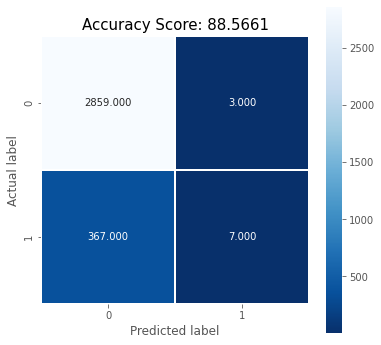

In [55]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

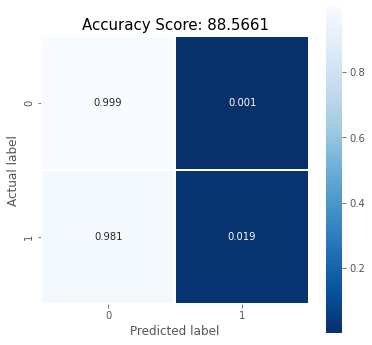

In [56]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [57]:
#Manera 1: To plot curves: #TODO: revisar
scaler = StandardScaler()
RF_clf=RandomForestClassifier(n_estimators=10, random_state = 42)
cv_RF = make_pipeline(scaler, RF_clf)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_RF_predicted = cross_val_predict(cv_RF, X,np.ravel(y),cv=kf, method='predict_proba')
cv_RF_predicted1 = cross_val_predict(cv_RF, X,np.ravel(y), cv=kf)
acc_RF=np.round(metrics.accuracy_score(np.ravel(y), cv_RF_predicted1)*100,4) #para accuracy_score debe ser ambos binary o ambos continues values

In [58]:
#manera 2
#https://amirhessam88.github.io/roc-vs-pr/

def customCrossValidationMetrics(classifier, X, y):
    scaler = StandardScaler()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    #ejemplo classifier=RandomForestClassifier(n_estimators=10, random_state = 42)
    aucprs = []
    aucrocs = []
    accuracies = []

    for train, test in cv.split(X, y): #train and test are indexes
        X_train_tranformed = scaler.fit_transform(X[train])
        X_test_tranformed = scaler.transform(X[test])
        probas_ = classifier.fit(X_train_tranformed, np.ravel(y[train])).predict_proba(X_test_tranformed)
        # Compute PR curve and area the curve
        precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1])
        pr_auc =  np.round(metrics.auc(recall, precision), 6)
        aucprs.append(pr_auc)
        auroc =  np.round(metrics.roc_auc_score(y[test],probas_[:, 1]),6)
        aucrocs.append(auroc)

        y_pred_binary=classifier.predict(X_test_tranformed)
        acc = np.round(metrics.accuracy_score(y[test],y_pred_binary)*100,4)
        accuracies.append(acc)

    print ('aucpr scores:', aucprs)
    print("%0.4f mean aucpr with a standard deviation of %0.4f" % (np.mean(aucprs), np.std(aucprs)))

    print ('aucroc scores:', aucrocs)
    print("%0.4f mean aucroc with a standard deviation of %0.4f" % (np.mean(aucrocs), np.std(aucrocs)))

    print ('accuracy scores:', accuracies)
    print("%0.4f mean accuracy with a standard deviation of %0.4f" % (np.mean(accuracies), np.std(accuracies)))
    
    return aucprs, aucrocs, accuracies


In [59]:
classifier=RandomForestClassifier(n_estimators=10, random_state = 42)
aucprs_RF, aucrocs_RF, accuracies_RF = customCrossValidationMetrics(classifier, X, y)

aucpr scores: [0.269771, 0.300152, 0.267277, 0.242272, 0.260992]
0.2681 mean aucpr with a standard deviation of 0.0187
aucroc scores: [0.711592, 0.721191, 0.72598, 0.708077, 0.70798]
0.7150 mean aucroc with a standard deviation of 0.0073
accuracy scores: [86.1164, 86.6367, 86.9442, 87.4645, 86.7991]
86.7922 mean accuracy with a standard deviation of 0.4373


Random Forest different class weight

In [60]:
clf=RandomForestClassifier(n_estimators=10, random_state = 42,class_weight='balanced')
clf.fit(X_train,np.ravel(y_train))
y_pred=clf.predict(X_test)
test_ac=np.round(metrics.accuracy_score(y_test, y_pred)*100,4)
train_ac=np.round(clf.score(X_train, y_train)*100,4)
print("Accuracy test:",test_ac)
print("Accuracy train:",train_ac)

Accuracy test: 60.754
Accuracy train: 60.2972


In [61]:
y_pred_probas=clf.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.7020430909165649
AUC-PR:  0.23959322393036656


In [62]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)


[[1690 1172]
 [  98  276]]


In [63]:
cm = metrics.confusion_matrix(y_test, y_pred)
score = np.round(clf.score(X_test, y_test)*100,4)

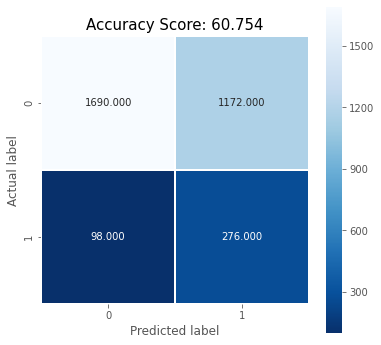

In [64]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

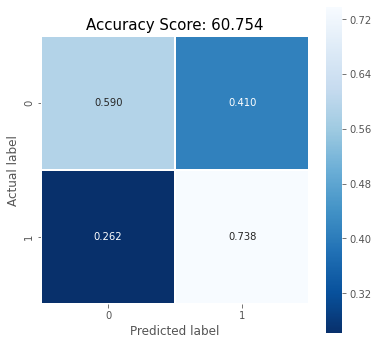

In [65]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
plt.show()

In [66]:
#Manera 2: To plot curves:
scaler = StandardScaler()
RF_clf_weighted=RandomForestClassifier(n_estimators=10, random_state = 42, class_weight='balanced')
cv_RF_weighted = make_pipeline(scaler, RF_clf_weighted)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_RF_weighted_predicted = cross_val_predict(cv_RF_weighted, X,np.ravel(y),cv=kf, method='predict_proba')
cv_RF_weighted_predicted1 = cross_val_predict(cv_RF_weighted, X,np.ravel(y), cv=kf)
acc_RF_weighted=np.round(metrics.accuracy_score(np.ravel(y), cv_RF_weighted_predicted1)*100,4)

In [67]:
classifier=RandomForestClassifier(n_estimators=10, random_state = 42, class_weight='balanced')
aucprs_RF_weighted, aucrocs_RF_weighted, accuracies_RF_weighted = customCrossValidationMetrics(classifier, X, y)

aucpr scores: [0.265597, 0.295643, 0.265212, 0.236281, 0.264632]
0.2655 mean aucpr with a standard deviation of 0.0188
aucroc scores: [0.710915, 0.719994, 0.724584, 0.706614, 0.707969]
0.7140 mean aucroc with a standard deviation of 0.0070
accuracy scores: [60.0757, 60.9508, 60.2176, 59.8628, 60.6577]
60.3529 mean accuracy with a standard deviation of 0.3964


Logistic Regression same class weight

In [68]:
logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)


Accuracy of logistic regression classifier on train set: 86.4436
Accuracy of logistic regression classifier on test set: 88.5043


In [69]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.7058066794470791
AUC-PR:  0.25577825644642876


In [70]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[2855    7]
 [ 365    9]]


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2862
           1       0.56      0.02      0.05       374

    accuracy                           0.89      3236
   macro avg       0.72      0.51      0.49      3236
weighted avg       0.85      0.89      0.84      3236



In [72]:
#Manera 2: To plot curves:
scaler = StandardScaler()
LR_clf=LogisticRegression()
cv_LR = make_pipeline(scaler, LR_clf)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_LR_predicted = cross_val_predict(cv_LR, X,np.ravel(y),cv=kf, method='predict_proba')
cv_LR_predicted1 = cross_val_predict(cv_LR, X,np.ravel(y), cv=kf)
acc_LR=np.round(metrics.accuracy_score(np.ravel(y), cv_LR_predicted1)*100,4)

In [73]:
classifier=LogisticRegression()
aucprs_LR, aucrocs_LR, accuracies_LR = customCrossValidationMetrics(classifier, X,y)

aucpr scores: [0.273167, 0.306137, 0.273412, 0.258166, 0.258734]
0.2739 mean aucpr with a standard deviation of 0.0174
aucroc scores: [0.712599, 0.721519, 0.727405, 0.705763, 0.708709]
0.7152 mean aucroc with a standard deviation of 0.0081
accuracy scores: [86.211, 86.5421, 86.8969, 87.6064, 86.5626]
86.7638 mean accuracy with a standard deviation of 0.4739


Logistic Regression different class weight

In [74]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, np.ravel(y_train))
y_pred = logreg.predict(X_test)
actr=np.round(100*logreg.score(X_train, y_train),4)
acte=np.round(100*logreg.score(X_test, y_test),4)
print('Accuracy of logistic regression classifier on train set:', actr)
print('Accuracy of logistic regression classifier on test set:', acte)

Accuracy of logistic regression classifier on train set: 65.6873
Accuracy of logistic regression classifier on test set: 66.5637


In [75]:
y_pred_probas=logreg.predict_proba(X_test)
auroc = metrics.roc_auc_score(y_test, y_pred_probas[:, 1])
print("AUC-ROC: ", auroc)
(precisions, recalls, thresholds) = metrics.precision_recall_curve(y_test, y_pred_probas[:, 1])
auprc = metrics.auc(recalls, precisions)
print("AUC-PR: ", auprc)


AUC-ROC:  0.7058066794470791
AUC-PR:  0.25577825644642876


In [83]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)

[[1905  957]
 [ 125  249]]


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      2862
           1       0.21      0.67      0.32       374

    accuracy                           0.67      3236
   macro avg       0.57      0.67      0.55      3236
weighted avg       0.85      0.67      0.73      3236



In [85]:
#Manera 2: To plot curves:
scaler = StandardScaler()
LR_clf_weighted=LogisticRegression(class_weight='balanced')
cv_LR_weighted = make_pipeline(scaler, LR_clf_weighted)
# Create k-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_LR_weighted_predicted = cross_val_predict(cv_LR_weighted, X,np.ravel(y),cv=kf, method='predict_proba')
cv_LR_weighted_predicted1 = cross_val_predict(cv_LR_weighted, X,np.ravel(y), cv=kf)
acc_LR_weighted=np.round(metrics.accuracy_score(np.ravel(y), cv_LR_weighted_predicted1)*100,4)

In [86]:
classifier=LogisticRegression(class_weight='balanced')
aucprs_LR_weighted, aucrocs_LR_weighted, accuracies_LR_weighted = customCrossValidationMetrics(classifier, X,y)

aucpr scores: [0.273167, 0.306137, 0.273412, 0.258166, 0.258734]
0.2739 mean aucpr with a standard deviation of 0.0174
aucroc scores: [0.712599, 0.721519, 0.727405, 0.705763, 0.708709]
0.7152 mean aucroc with a standard deviation of 0.0081
accuracy scores: [65.3974, 66.6509, 65.7285, 65.4447, 65.886]
65.8215 mean accuracy with a standard deviation of 0.4522


Plot ROC and PR curves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


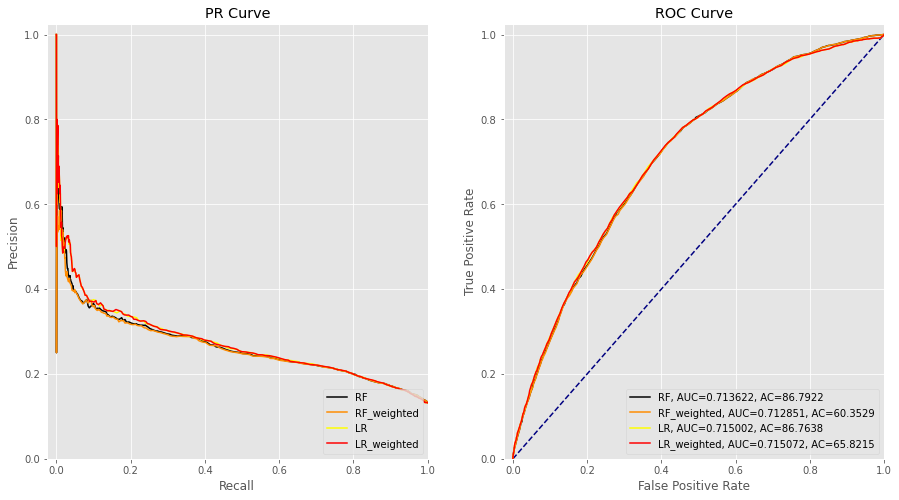

In [87]:
from sklearn.metrics import classification_report,confusion_matrix,auc,precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.025,1])
ax1.set_ylim([0,1.025])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax2.set_xlim([-0.025,1])
ax2.set_ylim([0,1.025])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

    
y_pred_proba=cv_RF_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="RF, AUC="+str(auc)+", AC="+str(acc_RF),color='black')
ax1.plot(r,p,label='RF',color='black')


y_pred_proba=cv_RF_weighted_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="RF_weighted, AUC="+str(auc)+", AC="+str(acc_RF_weighted),color='darkorange')
ax1.plot(r,p,label='RF_weighted',color='darkorange')
    
y_pred_proba=cv_LR_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="LR, AUC="+str(auc)+", AC="+str(acc_LR),color='yellow')
ax1.plot(r,p,label='LR',color='yellow')


y_pred_proba=cv_LR_weighted_predicted[::,1]
fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
p,r,_ = precision_recall_curve(y,y_pred_proba)
auc = np.round(metrics.roc_auc_score(y, y_pred_proba),6)
ax2.plot(fpr,tpr,label="LR_weighted, AUC="+str(auc)+", AC="+str(acc_LR_weighted),color='red')
ax1.plot(r,p,label='LR_weighted',color='red')

ax1.legend(loc='lower right')    
ax2.legend(loc='lower right')
plt.savefig('OASIS_mortality.eps', format='eps', dpi=1200)
plt.show()


In [81]:
print('RF vs RF_weighted: ', stats.ttest_rel(aucrocs_RF,aucrocs_RF_weighted))
print('RF_weighted vs LR: ', stats.ttest_rel(aucrocs_RF_weighted,aucrocs_LR))
print('LR vs LR_weighted: ', stats.ttest_rel(aucrocs_LR,aucrocs_LR_weighted))
print('LR_weighted vs RF: ', stats.ttest_rel(aucrocs_LR_weighted,aucrocs_RF))
print('LR_weighted vs RF_weighted: ', stats.ttest_rel(aucrocs_LR_weighted,aucrocs_RF_weighted))
print('LR vs RF: ', stats.ttest_rel(aucrocs_LR,aucrocs_RF))
#si p_value < 0.05, modelos tienen diferencias estadisticamente significativas   

RF vs RF_weighted:  Ttest_relResult(statistic=3.488639898710684, pvalue=0.025153867231297502)
RF_weighted vs LR:  Ttest_relResult(statistic=-1.9482083889066364, pvalue=0.12321032005797179)
LR vs LR_weighted:  Ttest_relResult(statistic=nan, pvalue=nan)
LR_weighted vs RF:  Ttest_relResult(statistic=0.3550397856104632, pvalue=0.740489133755428)
LR_weighted vs RF_weighted:  Ttest_relResult(statistic=1.9482083889066364, pvalue=0.12321032005797179)
LR vs RF:  Ttest_relResult(statistic=0.3550397856104632, pvalue=0.740489133755428)


Observamos que RF vs RF_weighted tienen pvalue = 0.02 < 0.05, por lo tanto, la hipotesi nula "las diferencias entre metricas de performance observadas en es probable que se deba al azar estadístico." es falsa. 
Las diferencias de las metricas (performance) entre estos dos modelos son estadisticamente significativas. RF es mejor que RF_weighted.

aucrocs_RF: [0.711592, 0.721191, 0.72598, 0.708077, 0.70798];  
0.7150 mean aucroc with a standard deviation of 0.0073

aucrocs_RF_weighted: [0.710915, 0.719994, 0.724584, 0.706614, 0.707969];  
0.7140 mean aucroc with a standard deviation of 0.0070

In [82]:
print('RF vs RF_weighted: ', stats.ttest_rel(aucprs_RF,aucprs_RF_weighted))
print('RF_weighted vs LR: ', stats.ttest_rel(aucprs_RF_weighted,aucprs_LR))
print('LR vs LR_weighted: ', stats.ttest_rel(aucprs_LR,aucprs_LR_weighted))
print('LR_weighted vs RF: ', stats.ttest_rel(aucprs_LR_weighted,aucprs_RF))
print('LR_weighted vs RF_weighted: ', stats.ttest_rel(aucprs_LR_weighted,aucprs_RF_weighted))
print('LR vs RF: ', stats.ttest_rel(aucprs_LR,aucprs_RF))


RF vs RF_weighted:  Ttest_relResult(statistic=1.5539839884394706, pvalue=0.1951548168464269)
RF_weighted vs LR:  Ttest_relResult(statistic=-1.9102188869348562, pvalue=0.12871344578861535)
LR vs LR_weighted:  Ttest_relResult(statistic=nan, pvalue=nan)
LR_weighted vs RF:  Ttest_relResult(statistic=1.983879664891226, pvalue=0.11827547693131153)
LR_weighted vs RF_weighted:  Ttest_relResult(statistic=1.9102188869348562, pvalue=0.12871344578861535)
LR vs RF:  Ttest_relResult(statistic=1.983879664891226, pvalue=0.11827547693131153)


las diferencias en aucpr de los modelos no son esdísticamente significativas.